In [2]:
!source .env3/bin/activate

In [3]:
import torch
print(torch.__version__)  # Versão do PyTorch
print(torch.version.cuda)  # Versão do CUDA

2.1.1+cu121
12.1


In [4]:
from fastcore.xtras import Path
from fastai.vision.all import *
from PIL import Image

In [5]:
data_path = Path("data/")
data_path.ls()

(#7) [Path('data/metal'),Path('data/trash'),Path('data/glass'),Path('data/cardboard'),Path('data/paper'),Path('data/plastic'),Path('data/.ipynb_checkpoints')]

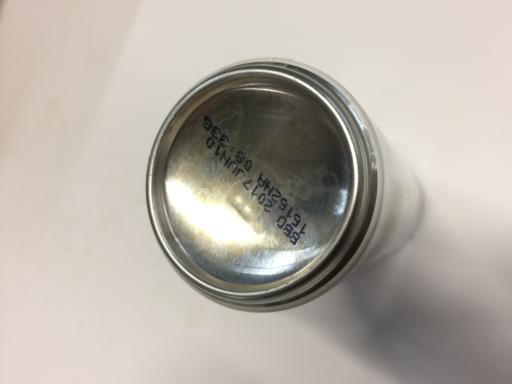

In [6]:
im_path = (data_path/'metal').ls()[0]
im = Image.open(im_path)
im

In [7]:
bad_imgs = []
classes = ['metal', 'trash', 'glass', 'cardboard', 'paper', 'plastic']
for c in classes:
    for im in (data_path/c).ls():
        try:
            _ = Image.open(im)
        except:
            bad_imgs.append(im)
            im.unlink()
bad_imgs, len(bad_imgs)

([], 0)

In [8]:
fnames = get_image_files(data_path)
fnames

(#2527) [Path('data/metal/metal145.jpg'),Path('data/metal/metal344.jpg'),Path('data/metal/metal66.jpg'),Path('data/metal/metal204.jpg'),Path('data/metal/metal293.jpg'),Path('data/metal/metal282.jpg'),Path('data/metal/metal303.jpg'),Path('data/metal/metal308.jpg'),Path('data/metal/metal57.jpg'),Path('data/metal/metal128.jpg')...]

## DataBlocks

In [16]:
dls.vocab

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [17]:
dls.vocab.o2i

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


/notebooks/kaggle-garbage-classification/.env3/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_

SuggestedLRs(valley=0.0020892962347716093)

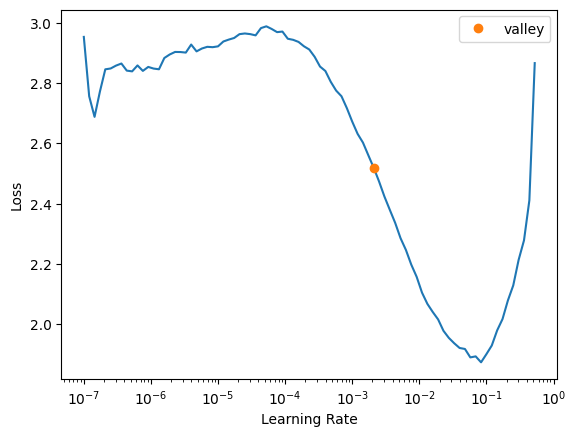

In [19]:
learn.lr_find()

In [20]:
learning_rate = 0.0020892962347716093

In [21]:
learn.fine_tune(10, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.507158,0.633381,0.207921,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.640950,0.462759,0.152475,00:13
1,0.460511,0.401761,0.128713,00:12
2,0.340295,0.497059,0.148515,00:12
3,0.266063,0.388702,0.106931,00:13
4,0.204662,0.363464,0.095050,00:13
5,0.151095,0.348619,0.095050,00:13
6,0.110797,0.299364,0.093069,00:13
7,0.079813,0.306228,0.085149,00:13
8,0.057349,0.287503,0.079208,00:13
9,0.042619,0.285895,0.077228,00:13


In [46]:
learn.path = Path('./')
learn.path

Path('.')

In [47]:
learn.save('fastai-ImageDataLoader')

Path('models/fastai-ImageDataLoader.pth')

## Predict

('cardboard',
 tensor(0),
 tensor([1.0000e+00, 5.5061e-10, 1.3912e-06, 4.6102e-07, 1.1120e-09, 6.9601e-09]))

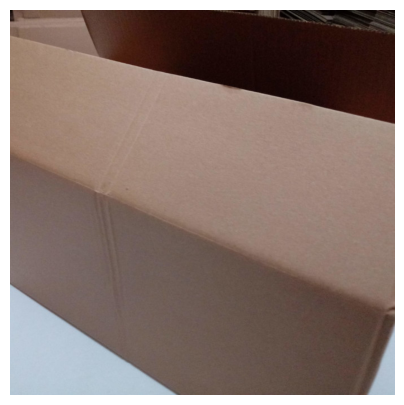

In [36]:
im_path = Path('caixa-papelao-grande-50-c-x-26-l-x-26-a-kit-20-unidades-caixa-papelao-correio.jpg')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)

In [25]:
learn.predict(im_path)

('cardboard',
 tensor(0),
 tensor([1.0000e+00, 5.5061e-10, 1.3912e-06, 4.6102e-07, 1.1120e-09, 6.9601e-09]))

('glass',
 tensor(1),
 tensor([2.6877e-03, 9.4678e-01, 4.9680e-03, 4.5891e-03, 4.0705e-02, 2.7143e-04]))

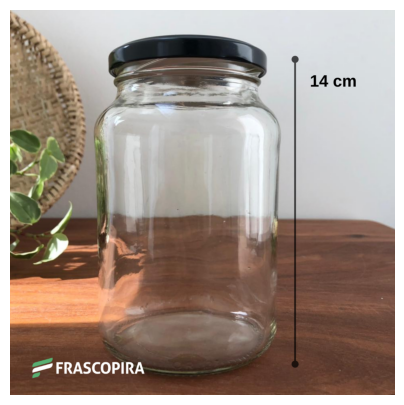

In [37]:
im_path = Path('pote_vidro_500g_com_tampa_74_mm_preta.png')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)

('glass',
 tensor(1),
 tensor([2.6877e-03, 9.4678e-01, 4.9680e-03, 4.5891e-03, 4.0705e-02, 2.7143e-04]))